# Assignment 1:  Superpixels and Image Segmentation.

Name: **Rishikesh Jadhav**

UID:  **119256534**

Link to Google Drive : **https://colab.research.google.com/drive/1zvfSnmvKF47lzLkR9kNwNU5QuKl-Zli0?usp=sharing**

Please submit a PDF containing all outputs to gradescope by **October 5, 11:59pm**

----------------------------

In this assignment, you will learn about superpixels. You will first generate superpixels by clustering pixels via k-means. This will generate a superpixel map such as the following:

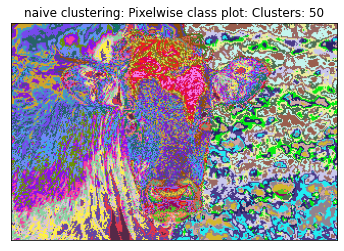

You will then implement a better superpixel algorithm: SLIC, which lets you generate superpixel maps like the following:

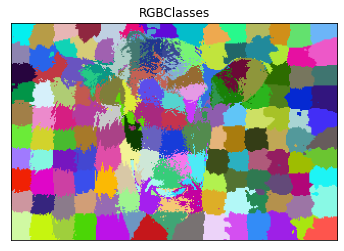

You will then build a segmentation network by training a deep neural network on your superpixels. This part is fairly open-ended, feel free to try any model you can think of (GNN, CNN, Transformer, etc.).

To give an example, for a CNN-based system that reformulates segmentation as superpixel image classification, there are basically three steps in the training stage:

1. Dilate and save each superpixel region from SLIC output into image of size 224X224, alongwith the ground truth segments label.
2. Build a couple of convolution layers to extract the deep features from each Superpixel patch image. Let the last layer be Fully connected layers.
3. Define the segmentation loss as multi-class classification loss and train a convolutional neural network based classifier.

Then, during inference, you would combine the classifier's predicted labels to form the whole input image's Superpixel segmentation results.

In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Part 1: Superpixels

For this first part of the assignment, you will implement 2 superpixels methods: k-means pixel clustering, and SLIC.

### Data

First, we download the MSRC labeled imaged database.

In [2]:
import os


# Define the target directory in your Google Drive
target_directory = '/content/drive/My Drive/CMSC828I_HW1'

# Change the current working directory to the target directory
os.chdir(target_directory)

# Check the current working directory to verify the location
print(f"Current directory: {os.getcwd()}")

Current directory: /content/drive/My Drive/CMSC828I_HW1


In [4]:
!wget http://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip
!unzip --qq msrc_objcategimagedatabase_v1.zip

--2023-10-02 17:05:45--  http://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.36.245.101, 2a02:26f0:fe00:295::317f, 2a02:26f0:fe00:29e::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.36.245.101|:80... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip [following]
--2023-10-02 17:05:45--  https://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip
Connecting to download.microsoft.com (download.microsoft.com)|23.36.245.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44119839 (42M) [application/octet-stream]
Saving to: ‘msrc_objcategimagedatabase_v1.zip’

msrc_objcategimaged 100%[===================>]  42.08M 

For the first part of this assignment, we will only use the following images. We define the list below as `im_list`.

In [3]:
im_list = ['MSRC_ObjCategImageDatabase_v1/1_22_s.bmp',
           'MSRC_ObjCategImageDatabase_v1/1_27_s.bmp',
           'MSRC_ObjCategImageDatabase_v1/3_3_s.bmp',
           'MSRC_ObjCategImageDatabase_v1/3_6_s.bmp',
           'MSRC_ObjCategImageDatabase_v1/6_5_s.bmp',
           'MSRC_ObjCategImageDatabase_v1/7_19_s.bmp']

import cv2
im = cv2.imread(im_list[0])
image_shape = im.shape

print(f"Image shape: {image_shape}")

Image shape: (213, 320, 3)


We provide the following functions as helpers for plotting your results. Please pay attention to their signatures and outputs.





In [4]:
#All important functions to plot
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

def plot_image(im, title, xticks = [], yticks = [], isCv2 = True):
    """
    im :Image to plot
    title : Title of image
    xticks : List of tick values. Defaults to nothing
    yticks :List of tick values. Defaults to nothing
    cv2 :Is the image cv2 image? cv2 images are BGR instead of RGB. Default True
    """
    plt.figure()
    if isCv2:
        im = im[:,:,::-1]
    plt.imshow(im)
    plt.title(title)
    plt.xticks(xticks)
    plt.yticks(yticks)

def superpixel_plot(im,seg,title = "Superpixels"):
    """
    Given an image (nXmX3) and pixelwise class mat (nXm),
    1. Consider each class as a superpixel
    2. Calculate mean superpixel value for each class
    3. Replace the RGB value of each pixel in a class with the mean value

    Inputs:
    im: Input image
    seg: Segmentation map
    title: Title of the plot

    Output: None
    Creates a plot
    """
    clust = np.unique(seg)
    mapper_dict = {i: im[seg == i].mean(axis = 0)/255. for i in clust}

    seg_img =  np.zeros((seg.shape[0],seg.shape[1],3))
    for i in clust:
        seg_img[seg == i] = mapper_dict[i]

    plot_image(seg_img,title)

    return

def rgb_segment(seg,n = None,plot = True,title=None,legend = True,color = None):
    """
    Given a segmentation map, get the plot of the classes
    """
    clust = np.unique(seg)
    if n is None:
        n = len(clust)
    if color is None:
        cm = plt.cm.get_cmap('hsv',n+1)
        # mapper_dict = {i:np.array(cm(i/n)) for i in clust}
        mapper_dict = {i:np.random.rand(3,) for i in clust}
    #elif color == 'mean':
        #TODO..get the mean color of cluster center and assign that to mapper_dict

    seg_img =  np.zeros((seg.shape[0],seg.shape[1],3))
    for i in clust:
        seg_img[seg == i] = mapper_dict[i][:3]

    if plot:
        plot_image(seg_img,title = title)
    if legend:
        # get the colors of the values, according to the
        # colormap used by imshow
        patches = [ mpatches.Patch(color=mapper_dict[i], label=" : {l}".format(l=i) ) for i in range(n) ]
        # put those patched as legend-handles into the legend
        plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
        plt.grid(True)
        plt.show()

    return seg_img

For example, the following code uses `plot_image` to plot the 6 images we are using for this assignment.

In [7]:
for i in im_list:
    plot_image(cv2.imread(i),i.split("/")[-1])

Output hidden; open in https://colab.research.google.com to view.

### Question 1: Perform k-means on image pixels `(r, g, b, x, y)`. (40 points)

The k-means clustering algorithm is an unsupervised algorithm which, for some items and for some specified number of clusters represented by cluster centers, minimizes the distance between items and their associated cluster centers. It does so by iteratively assigning items to a cluster and recomputing the cluster center based on the assigned items.

Complete the pixel clustering function. It should take input an image (shape = `(n, m, 3)`) and number of clusters. Each pixel should be represented by a vector with 3 values: `(r, g, b, x, y)`.

Then, let our provided code plot the pixelwise and superpixel plots for the cow image (`1_22_s.bmp`), using your `cluster_pixels` implementation with the provided values for the number of clusters: `5, 10, 25, 50, 150`.




In [ ]:
from sklearn.cluster import KMeans
import numpy as  np


def cluster_rgbxy(im,k):
    """
    Given image im and asked for k clusters, return nXm size 2D array
    segmap[0,0] is the class of pixel im[0,0,:]
    """
    # Get the height and width of the image
    n, m, _ = im.shape

    # Reshape the image to a 2D array of pixels where each pixel is represented by a vector with 3 values.
    pixels = im.reshape(-1, 3)

    # Initialize and fit the KMeans model
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=0).fit(pixels)

    # Get the cluster assignments for each pixel
    segmap = kmeans.labels_.reshape(n, m)

    # assert 1==2," NOT IMPLEMENTED"
    #segmap is nXm. Each value in the 2D array is the cluster assigned to that pixel
    return segmap

im = cv2.imread(im_list[0])
for k in [5, 10, 25, 50, 150]:
    clusters = cluster_rgbxy(im,k)
    # Ensure that 'clusters' (segmap) has the same dimensions as 'im'
    assert clusters.shape == (im.shape[0], im.shape[1])
    _ = rgb_segment(clusters,n = k, title =  "naive clustering: Pixelwise class plot: Clusters: " + str(k),legend = False)
    superpixel_plot(im,clusters,title =  "naive clustering: Superpixel plot: Clusters: "+ str(k))

Output hidden; open in https://colab.research.google.com to view.

Pick your favorite superpixel **k** value and plot results for all 6 images in `im_list`.

In [ ]:
# TODO: plot for 6 images with chosen k value
k =25
for image in im_list:
  im = cv2.imread(image)
  clusters = cluster_rgbxy(im,k)
  # Ensure that 'clusters' (segmap) has the same dimensions as 'im'
  assert clusters.shape == (im.shape[0], im.shape[1])
  _ = rgb_segment(clusters,n = k, title =  "naive clustering: Pixelwise class plot: Clusters: " + str(k),legend = False)
  superpixel_plot(im,clusters,title =  "naive clustering: Superpixel plot: Clusters: "+ str(k))


Output hidden; open in https://colab.research.google.com to view.

### Question 2: Replicate SLIC and Show Results for 6 Images (50 points)

It doesn't look like we have a very favourable outcome with superpixels being implemented with simple clustering. Can we do better? Have a look at the SLIC paper [here](https://www.iro.umontreal.ca/~mignotte/IFT6150/Articles/SLIC_Superpixels.pdf). Incorporate S and m and redefine your distance metric as per the paper.

**Finding an existing implementation of SLIC and using it for your assigment would be considered cheating.**

In [5]:
import numpy as np
import cv2

In [ ]:
############Algorithm############
#Compute grid steps: S
#you can explore different values of m
#initialize cluster centers [l,a,b,x,y] using
#Perturb for minimum G
#while not converged
##for every pixel:
####  compare distance D_s with each cluster center within 2S X 2S.
####  Assign to nearest cluster
##calculate new cluster center


# Function to initialize cluster centers
def initialize_centers(im, k):
    # Calculate S based on the number of clusters (k) and image dimensions
    S = int(np.sqrt(im.shape[0] * im.shape[1] / k))
    # Initialize cluster centers with a regular grid
    centers = []
    for x in range(S // 2, im.shape[1], S):
        for y in range(S // 2, im.shape[0], S):
            if x < im.shape[1] and y < im.shape[0]:
                center = (x, y, im[y, x, 0], im[y, x, 1], im[y, x, 2])
                centers.append(center)

    return np.array(centers)

# Function to compute distance between a pixel and a center
def compute_distance(pixel, center, S):
    dx = pixel[0] - center[0]
    dy = pixel[1] - center[1]
    ds = np.sqrt(dx**2 + dy**2)
    dc = np.sqrt((pixel[2] - center[2])**2 + (pixel[3] - center[3])**2 + (pixel[4] - center[4])**2)
    return ds + dc


def SLIC(im, k):
    """
    Input arguments:
    im: image input
    k: number of cluster segments


    Compute
    S: As described in the paper
    m: As described in the paper (use the same value as in the paper)
    follow the algorithm..

    returns:
    segmap: 2D matrix where each value corresponds to the image pixel's cluster number
    """
    # Calculate S based on the number of clusters (k) and image dimensions
    S = int(np.sqrt(im.shape[0] * im.shape[1] / k))

    # Initialize cluster centers
    centers = initialize_centers(im, k)

    # Create an array to store the cluster assignments
    segmap = np.zeros(im.shape[:2], dtype=int)

    # Maximum number of iterations
    max_iterations = 100
    for _ in range(max_iterations):
        # Assign each pixel to the nearest cluster center
        for y in range(im.shape[0]):
            for x in range(im.shape[1]):
                pixel = (x, y, im[y, x, 0], im[y, x, 1], im[y, x, 2])
                min_distance = float('inf')
                cluster_id = -1
                for i, center in enumerate(centers):
                    distance = compute_distance(pixel, center, S)
                    if distance < min_distance:
                        min_distance = distance
                        cluster_id = i
                segmap[y, x] = cluster_id

        # Update cluster centers
        new_centers = np.zeros_like(centers, dtype=float)  # Ensure new_centers is of float type
        cluster_sizes = np.zeros(k)
        for y in range(im.shape[0]):
            for x in range(im.shape[1]):
                cluster_id = segmap[y, x]
                cluster_sizes[cluster_id] += 1
                new_centers[cluster_id] += [x, y, im[y, x, 0], im[y, x, 1], im[y, x, 2]]
        for i in range(k):
            if cluster_sizes[i] != 0:
                new_centers[i] /= cluster_sizes[i]
        centers = new_centers

    return segmap


With SLIC implemented, plot results for all 6 images.

In [ ]:
## TODO: Call our plot functions with your SLIC results for all 6 images
k = 300
im = cv2.imread(im_list[0])
clusters = SLIC(im, k)
unique_clusters = np.unique(clusters)
print("Number of unique clusters:", len(unique_clusters))

# Ensure that 'clusters' (segmap) has the same dimensions as 'im'
assert clusters.shape == (im.shape[0], im.shape[1])
# Further processing or visualization can be added here
_ = rgb_segment(clusters,n = k, title =  "naive clustering: Pixelwise class plot: Clusters: " + str(k),legend = False)
superpixel_plot(im,clusters,title =  "naive clustering: Superpixel plot: Clusters: "+ str(k))

KeyboardInterrupt: ignored

### Question 3: What advantage did the SLIC give compared to `(r, g, b, x, y)`? Please answer in 3 sentences or fewer. (10 points)

Your Answer:

### Bonus Question 4: Enforce connectivity (20 points, OPTIONAL)
There are many superpixels which are very small and disconnected from each other. Merge them with larger superpixels

O(N) algorithm:
1. Set minimum size of superpixel
2. If region smaller than threshold, assign to nearest cluster

Plot results for the 6 images.


## Part 2: Segmentation

For this part, you will use your best superpixels to build an image segmentation system. Alternatively, you can use SLIC from some library, as we demonstrate in the Data section that follows.

### Data

This is mostly the same as the last part, except now we also need to consider the annotated ground truth segmentation maps.

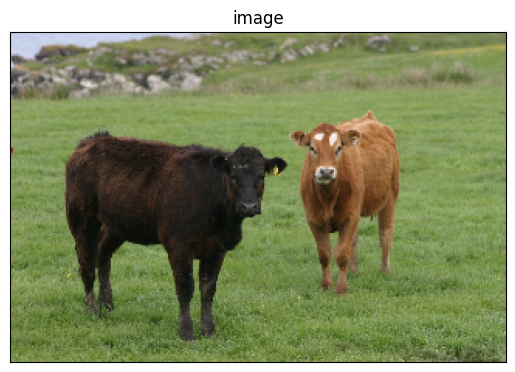

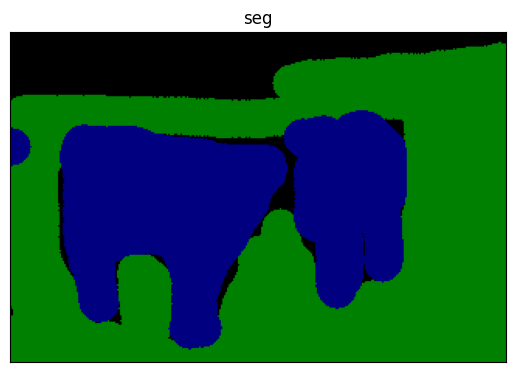

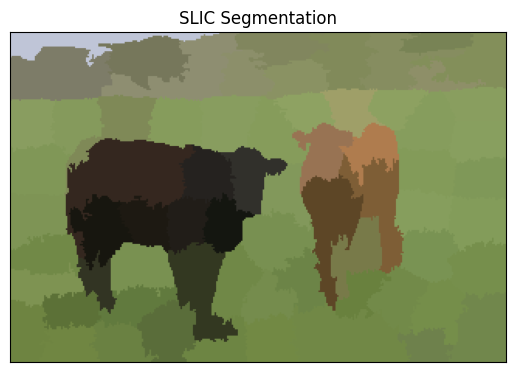

In [6]:
#  plot a sample image and its ground truth segments
image_sample = cv2.imread('MSRC_ObjCategImageDatabase_v1/1_19_s.bmp')
seg_sample = cv2.imread('MSRC_ObjCategImageDatabase_v1/1_19_s_GT.bmp')
plot_image(image_sample, 'image')
plot_image(seg_sample, 'seg')

#  run SLIC on the sample image and plot the corresponding SLIC segments
from skimage.segmentation import slic

segments_sample = slic(image_sample, n_segments=100, compactness=10)
superpixel_plot(image_sample, segments_sample, title = "SLIC Segmentation")

In [7]:
from IPython import embed
import os
current_directory = os.getcwd()
print(current_directory)
msrc_directory = current_directory + '/MSRC_ObjCategImageDatabase_v1'

#Superpixel dataset preparation

# from Dataset_v1
SEG_LABELS_LIST_v1 = [
    {"id": -1, "name": "void",       "rgb_values": [0,   0,    0]},
    {"id": 0,  "name": "building",   "rgb_values": [128, 0,    0]},
    {"id": 1,  "name": "grass",      "rgb_values": [0,   128,  0]},
    {"id": 2,  "name": "tree",       "rgb_values": [128, 128,  0]},
    {"id": 3,  "name": "cow",        "rgb_values": [0,   0,    128]},
    {"id": 4,  "name": "sky",        "rgb_values": [128, 128,  128]},
    {"id": 5,  "name": "airplane",   "rgb_values": [192, 0,    0]},
    {"id": 6, "name": "face",       "rgb_values": [192, 128,  0]},
    {"id": 7, "name": "car",        "rgb_values": [64,  0,    128]},
    {"id": 8, "name": "bicycle",    "rgb_values": [192, 0,    128]},
    {"id": -1, "name": "horse",       "rgb_values": [128,   0,    128]},
    {"id": -1, "name": "water",       "rgb_values": [64,   128,    0]},
    {"id": -1, "name": "mountain",       "rgb_values": [64,   0,    0]},
    {"id": -1, "name": "sheep",       "rgb_values": [0,   128,    128]}]

# from Dataset_v2
SEG_LABELS_LIST_v2 = [
    {"id": -1, "name": "void",       "rgb_values": [0,   0,    0]},
    {"id": 0,  "name": "building",   "rgb_values": [128, 0,    0]},
    {"id": 1,  "name": "grass",      "rgb_values": [0,   128,  0]},
    {"id": 2,  "name": "tree",       "rgb_values": [128, 128,  0]},
    {"id": 3,  "name": "cow",        "rgb_values": [0,   0,    128]},
    {"id": 4,  "name": "horse",      "rgb_values": [128, 0,    128]},
    {"id": 5,  "name": "sheep",      "rgb_values": [0,   128,  128]},
    {"id": 6,  "name": "sky",        "rgb_values": [128, 128,  128]},
    {"id": 7,  "name": "mountain",   "rgb_values": [64,  0,    0]},
    {"id": 8,  "name": "airplane",   "rgb_values": [192, 0,    0]},
    {"id": 9,  "name": "water",      "rgb_values": [64,  128,  0]},
    {"id": 10, "name": "face",       "rgb_values": [192, 128,  0]},
    {"id": 11, "name": "car",        "rgb_values": [64,  0,    128]},
    {"id": 12, "name": "bicycle",    "rgb_values": [192, 0,    128]},
    {"id": 13, "name": "flower",     "rgb_values": [64,  128,  128]},
    {"id": 14, "name": "sign",       "rgb_values": [192, 128,  128]},
    {"id": 15, "name": "bird",       "rgb_values": [0,   64,   0]},
    {"id": 16, "name": "book",       "rgb_values": [128, 64,   0]},
    {"id": 17, "name": "chair",      "rgb_values": [0,   192,  0]},
    {"id": 18, "name": "road",       "rgb_values": [128, 64,   128]},
    {"id": 19, "name": "cat",        "rgb_values": [0,   192,  128]},
    {"id": 20, "name": "dog",        "rgb_values": [128, 192,  128]},
    {"id": 21, "name": "body",       "rgb_values": [64,  64,   0]},
    {"id": 22, "name": "boat",       "rgb_values": [192, 64,   0]}]

# create a map rgb_2_label, where mapping the ground truth 3-d array segmentation into a single ID label.
rgb_2_label = {}
for i in SEG_LABELS_LIST_v1:
    rgb_2_label[tuple(i['rgb_values'])] = i['id']

/content/drive/My Drive/CMSC828I_HW1


### Question 5: Superpixel Dataset (30 points)

First, we dilate each superpixel and save the output superpixel patch from SLIC into 224X224 size image (after rescaling), alongwith the ground truth segments label.

For the purpose of consistency, we adopt the existing SLIC implementation from the scikit-learn machine learning package.

Suggested algorithm: Save the superpixels along with their segmentation class. You could implement this as follows:

For each image
1. Get superpixels sp_i for image x. We adopt 100 segments in this assignment, 'segments = slic(image, n_segments=100, compactness=10)'.
2. For every superpixel sp_i in the image, \\
    2.1. find the smallest rectangle which can enclose sp_i <br>
    2.2. Dilate the rectangle by 3 pixels.<br>
    2.3. Get the same region from the segmentation image (from the file with similar name with *_GT). The class for this sp_i is mode of segmentation classes in that same region. Save the dilated region as npy (jpg is lossy for such small patches).<br>


Alternatively, you could create a single csv with columns segment patch location, class label for each sp_i of each image.<br>italicized text

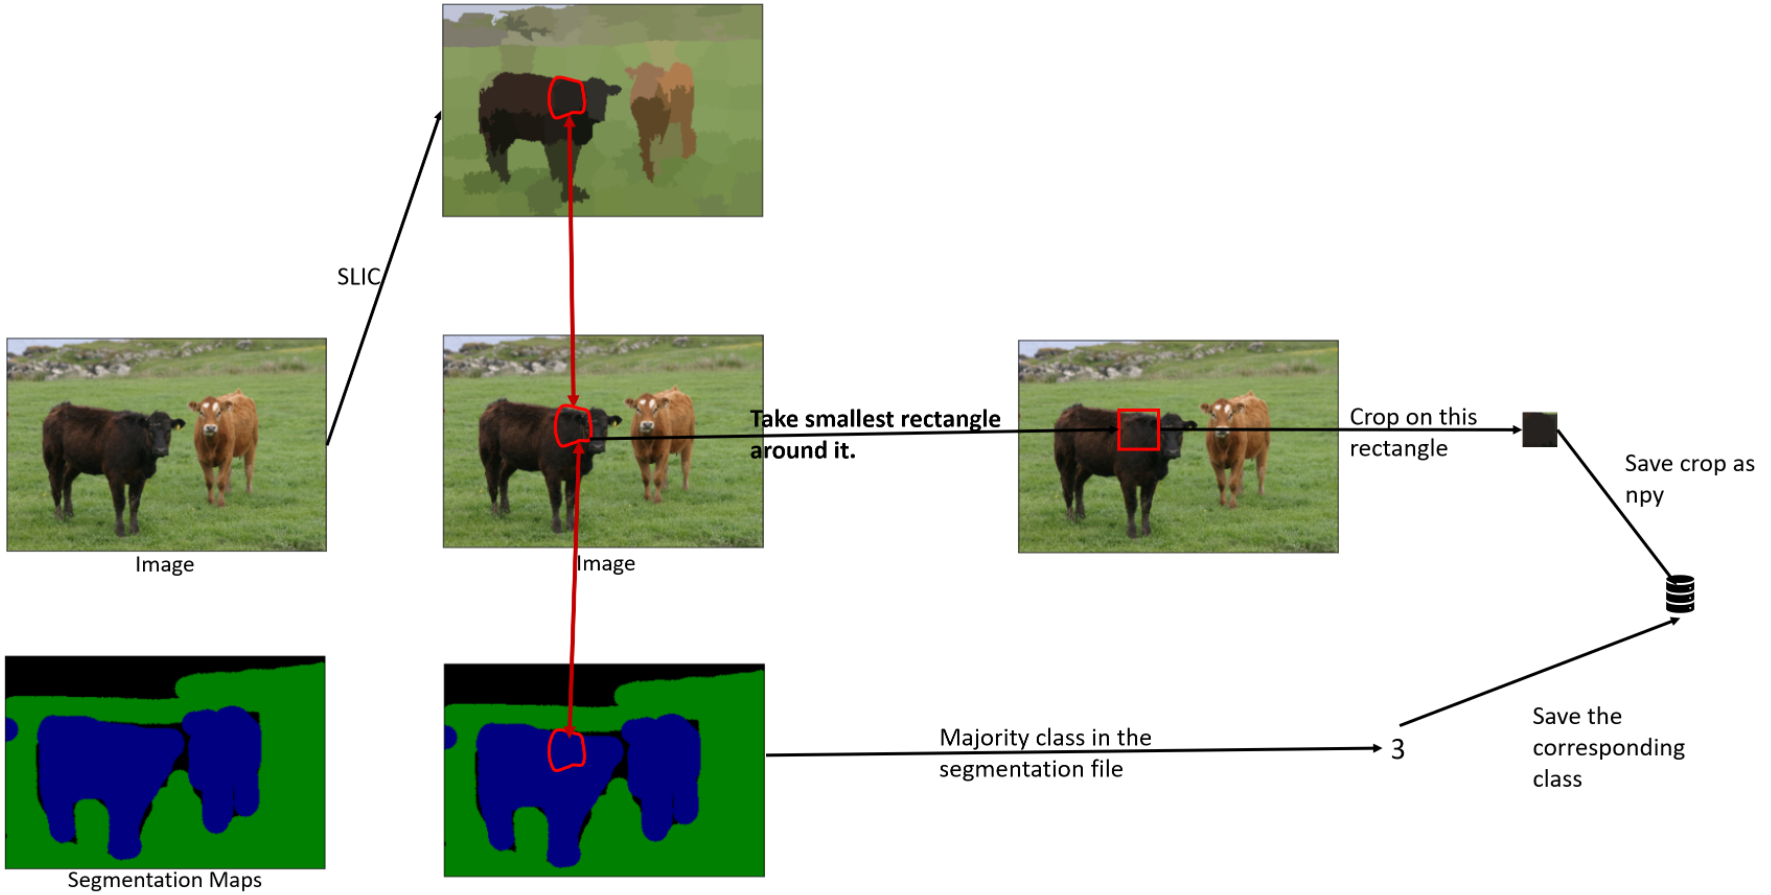


In addition to your code, **the primary graded deliverables** for this question are the 12 demo images we request after you have written code for the dataset.

In [13]:
pip install tqdm

In [41]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from skimage.segmentation import slic
from scipy import ndimage
from scipy import stats
from scipy.stats import mode
import matplotlib.pyplot as plt
import pandas as pd
from scipy import ndimage as ndi
from skimage.measure import regionprops
from skimage.io import imsave

Original file

  

In [59]:
# run SLIC on each original images and save the (segment patch, ID label) pair
# segments = slic(image, n_segments=100, compactness=10)
# it may take up to half an hour to process, depending on the hardware resources
# save the output file names to train.txt
# Alternatively, you don't save the segment patch and ID label offline, instead,
# you process them on the fly later.

import os
from sklearn.model_selection import train_test_split
import os
import cv2
import numpy as np
from skimage.segmentation import slic
from skimage.io import imsave
from tqdm import tqdm
import pandas as pd

# STEPS
# 1. Data Preparation: Seperate/Sort image and ground truth segmentation files for further processing.
# 2. Perform superpixel segmentation on the images using the SLIC algorithm(segments = slic(image, n_segments=100, compactness=10))
# 3. Bounding Box Extraction: Extract bounding boxes for each superpixel in the segmented images
# 4. Label Assignment: Assign class labels to the extracted bounding boxes based on the majority class in the corresponding ground truth segmentation patch(mode)
# 5. Saving Extracted Patches: Save the extracted image patches and their corresponding labels as .npy files. The file paths and labels are also recorded in a CSV file for later use.
# 6. Data Splitting: The code splits the dataset into training and test sets using train_test_split from scikit-learn.
# 7. A CSV file is created to store information about the saved patches and their labels as mentioned in the instructions.

current_directory = os.getcwd()
# print(current_directory)
msrc_directory = current_directory + '/MSRC_ObjCategImageDatabase_v1'

# Get lists of image files and corresponding ground truth files
image_files = sorted([os.path.join(msrc_directory, file) for file in os.listdir(msrc_directory) if file.endswith("s.bmp")])
ground_truth_files = sorted([os.path.join(msrc_directory, file) for file in os.listdir(msrc_directory) if file.endswith("GT.bmp")])

# Check if the number of image files matches the number of ground truth files
assert len(image_files) == len(ground_truth_files), f"Datasize mismatch GTfiles: {len(ground_truth_files)} imfiles: {len(image_files)}"

# Split the data into training and testing sets
training_images, testing_images, training_gt_images, testing_gt_images = train_test_split(image_files, ground_truth_files, test_size=0.2, random_state=42)

# Print the sizes of the training and testing sets
print(f"Number of training images: {len(training_images)}")
print(f"Number of testing images: {len(testing_gt_images)}")

# Define a dictionary mapping RGB colors to class labels (rgb_2_label)
# This mapping should be based on your dataset's specific class labels and colors

def get_patches(image_files, ground_truth_files, rgb_2_label, mode='train'):
    root, _ = os.path.split(image_files[0])
    if not os.path.isdir(root + f'/{mode}/'):
        print(root + "  was not present, creating the folder...")
        os.makedirs(root + f'/{mode}/')
# len(image_files)
    metafile = []
    for i in tqdm(range(len(image_files))):
       # Load the image and corresponding ground truth segmentation
        image = cv2.imread(image_files[i])[:, :, ::-1]
        ground_truth  = cv2.imread(ground_truth_files[i])[:, :, ::-1]

        # Perform superpixel segmentation using SLIC algorithm
        seg_map = slic(image, n_segments=100, compactness=10) # as instructed in the question.

        nonecounter = 0
        for seg_id in np.unique(seg_map):
            h, w = seg_map.shape
            seg_indices = np.where(seg_map == seg_id)
            n_dilate = 3

            if len(seg_indices[0]):
                y_min, y_max = min(seg_indices[0]), max(seg_indices[0])
                x_min, x_max = min(seg_indices[1]), max(seg_indices[1])
                #DILATION
                x_min, x_max = max(0, x_min - n_dilate), min(w, x_max + n_dilate)
                y_min, y_max = max(0, y_min - n_dilate), min(h, y_max + n_dilate)
                (y1, x1), (y2, x2) = (y_min, x_min), (y_max, x_max)

                seg_patch = image[y1:y2, x1:x2, :]
                if seg_patch.shape[0] >= 5 and seg_patch.shape[1] >= 5:

                    gt_patch = ground_truth[y1:y2, x1:x2, :]
                    patch_label = -1  # Initialize as -1
                    label_dict = {}
                    labels = np.unique(list(rgb_2_label.values()))
                    for label in labels:
                        label_dict[label] = 0

                    h, w = gt_patch.shape[:2]
                    for y in range(h):
                        for x in range(w):
                            color = tuple(gt_patch[y, x])
                            label = rgb_2_label.get(color, -1)
                            label_dict[label] += 1

                    patch_label  = max(label_dict, key=label_dict.get)
                    # Save the extracted patch and label as .npy files

                    _, imfilename = os.path.split(image_files[i])
                    savefilename = root + f'/{mode}/' + imfilename.replace('.bmp', f'_C{seg_id}_.npy')
                    np.save(savefilename, seg_patch)
                    metafile.append([savefilename, patch_label])

            else:
                nonecounter += 1

        if nonecounter:
            print(f"{nonecounter}/{100} no.of empty segments in {imfilename}")

    # Create a CSV file to store information about saved patches and labels
    metadf = pd.DataFrame(metafile, columns=['path', 'label'])
    metadf.to_csv(f'{root}/{mode}meta.csv')
    #metadf.to_csv('/content/drive/MyDrive/CMSC828I_HW1/MSRC_ObjCategImageDatabase_v1/train/meta.csv')


Number of training images: 192
Number of testing images: 48


In [60]:
# Example usage:
get_patches(training_images, training_gt_images, rgb_2_label, mode='train')

100%|██████████| 192/192 [05:22<00:00,  1.68s/it]


In [61]:
get_patches(testing_images, testing_gt_images, rgb_2_label, mode='test')

100%|██████████| 48/48 [08:37<00:00, 10.79s/it]


In [62]:
traindf = pd.read_csv(f'{msrc_directory}/trainmeta.csv')
print("train df value counts \n", traindf.label.value_counts())

train df value counts 
 -1    3289
 1    2649
 4    1481
 0    1143
 7     755
 2     632
 3     624
 6     327
 5     292
 8     242
Name: label, dtype: int64


In [63]:
testdf = pd.read_csv(f'{msrc_directory}/testmeta.csv')
print("test df value counts \n", testdf.label.value_counts())

test df value counts 
 -1    982
 1    746
 4    316
 0    269
 6    158
 7    139
 2    133
 3    105
 5     85
 8     71
Name: label, dtype: int64


(74, 34, 3)


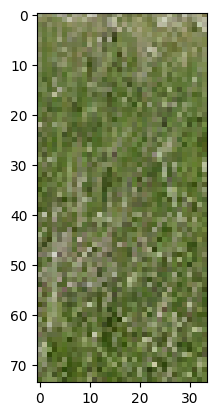

In [64]:
import numpy as np

data = np.load('/content/drive/MyDrive/CMSC828I_HW1/MSRC_ObjCategImageDatabase_v1/train/1_6_s_C5_.npy')
import matplotlib.pyplot as plt
print(data.shape)
plt.imshow(data, cmap='gray')  # 'gray' colormap for grayscale images
plt.show()

/content/drive/MyDrive/CMSC828I_HW1


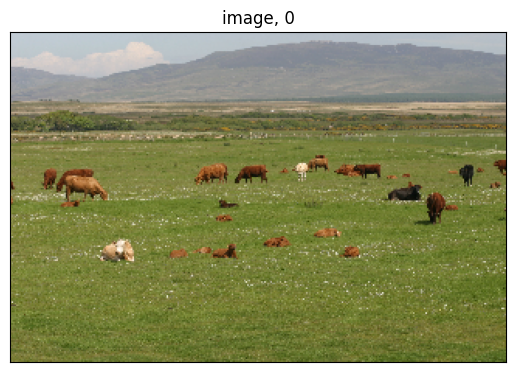

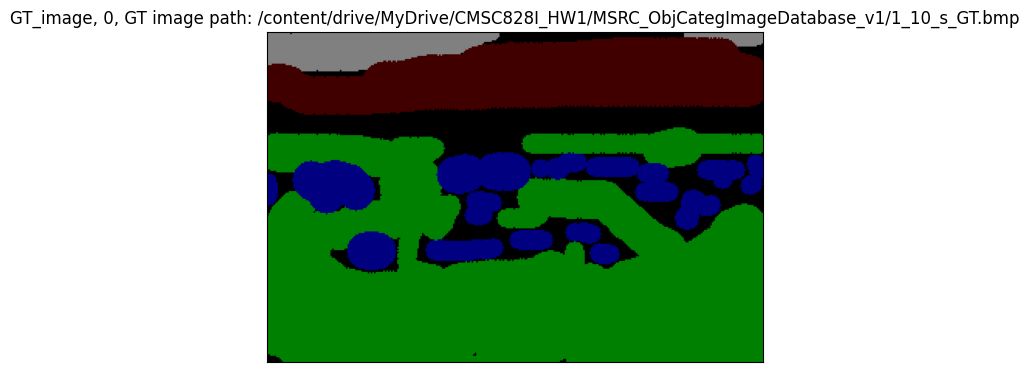

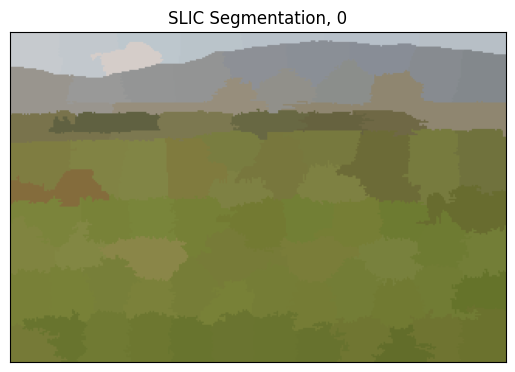

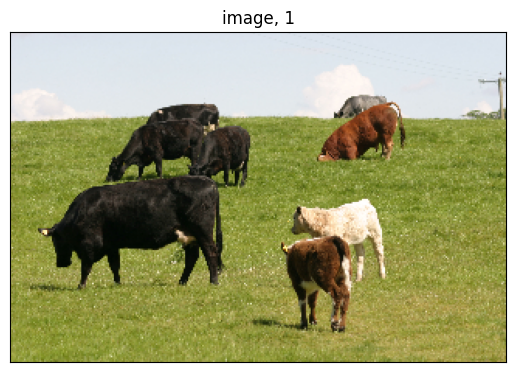

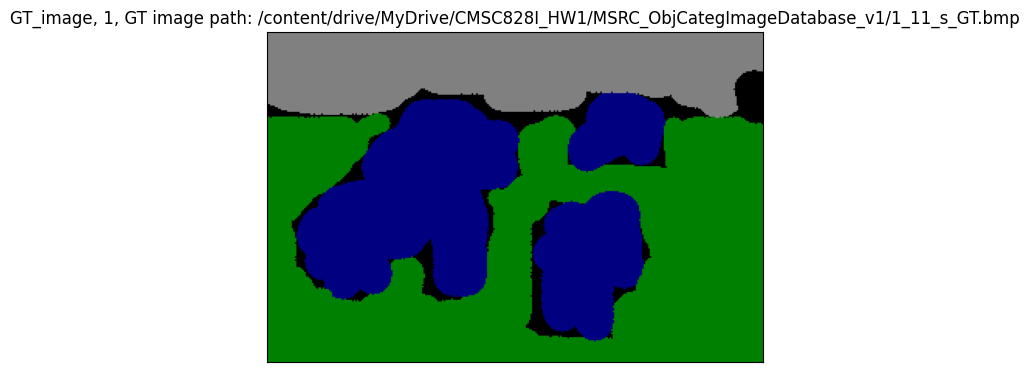

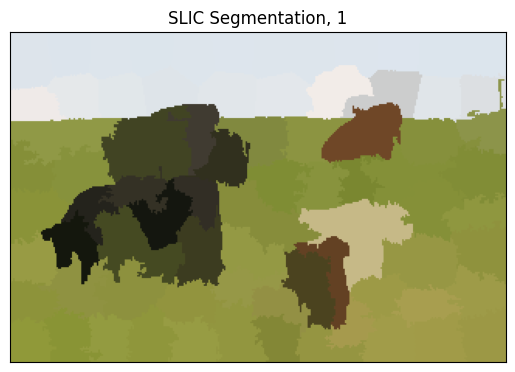

In [35]:
# run SLIC on each original images and save the (segment patch, ID label) pair
# segments = slic(image, n_segments=100, compactness=10)
# it may take up to half an hour to process, depending on the hardware resources
# save the output file names to train.txt
# Alternatively, you don't save the segment patch and ID label offline, instead,
# you process them on the fly later.
import os
import pandas as pd
from sklearn.model_selection import train_test_split

current_directory = os.getcwd()
print(current_directory)
msrc_directory = current_directory + '/MSRC_ObjCategImageDatabase_v1'
output_directory = './superpixels/'

if not os.path.exists(output_directory):
    os.makedirs(output_directory)

if os.path.exists('./datasets/train.txt'):
    os.remove('./datasets/train.txt')

# Initialize an empty list to store (segment patch, ID label) pairs
segment_label_pairs = []

# Track the number of processed images
num_processed_images = 0

# Define the function to compute the mode of a list
def mode(lst):
    try:
        return max(set(lst), key=lst.count)
    except:
        return None

image_files = sorted([os.path.join(msrc_directory, file) for file in os.listdir(msrc_directory) if file.endswith("s.bmp")])
ground_truth_files = sorted([os.path.join(msrc_directory, file) for file in os.listdir(msrc_directory) if file.endswith("GT.bmp")])

for filename in os.listdir(msrc_directory):
    # Your code
    # Check if the file is an image (you can add more image extensions if needed)
    if filename.endswith('.bmp') and not filename.endswith('_GT.bmp'):
        image_name = filename
        gt_name = filename.replace('.bmp', '_GT.bmp')

        # Create the full path to the image
        image_path = os.path.join(msrc_directory, image_name)
        # Load the image
        image = cv2.imread(image_path)
        # Perform SLIC segmentation on the image
        segments = slic(image, n_segments=100, compactness=10)

        # Construct the corresponding GT image filename
        # gt_image_filename = filename.replace('.bmp', '') + '_GT.bmp'
        # Create the full path to the GT image by joining the directory and the GT image filename
        full_gt_image_path = os.path.join(msrc_directory, gt_name)

        # Load the corresponding GT image
        gt_image = cv2.imread(full_gt_image_path)

        # # Append the (segment patch, ID label) pair to the list
        # segment_label_pairs.append((segments, gt_image))

        #PLOTS OF 2 IMAGES
        plot_image(image, f'image, {num_processed_images}')
                # Check if the GT image is loaded successfully before plotting it

        if gt_image is not None:
            plot_image(gt_image, f'GT_image, {num_processed_images}, GT image path: {full_gt_image_path}')
        else:
            print(f'GT image not available for image {num_processed_images}, GT image path: {full_gt_image_path}')

        superpixel_plot(image, segments, title = f"SLIC Segmentation, {num_processed_images}")

        # Increment the count of processed images
        num_processed_images += 1

        # Add a break statement to exit the loop when the count goes above 3
        if num_processed_images >= 2:
            break
    # pass


In [80]:
import os
import numpy as np
import torch
import torch.utils.data as data
from PIL import Image
from torchvision import transforms
import _pickle as pickle
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

# -------------
# Dataset class
# -------------
#
# ``torch.utils.data.Dataset`` is an abstract class representing a
# dataset.
# Your custom dataset should inherit ``Dataset`` and override the following
# methods:
#
# -  ``__len__`` so that ``len(dataset)`` returns the size of the dataset.
# -  ``__getitem__`` to support the indexing such that ``dataset[i]`` can
#    be used to get sp_i sample
#
# Let's create a dataset class for our superpixel dataset. We will
# read the csv in ``__init__`` but leave the reading of images to
# ``__getitem__``. This is memory efficient because all the images are not
# stored in the memory at once but read as required.
#
# Sample of our dataset will be a dict
# ``{'superpixel image': image, 'superpixel class': class}``. Our dataset will take an
# optional argument ``transform`` so that any required processing can be
# applied on the sample. Remember to resize the image using ``transform``.

class SegmentationData(data.Dataset):

    def __init__(self,path,mode,transform=None):
        # Your code
      self.df = pd.read_csv(f'{path}/{mode}/{mode}meta.csv', skiprows=1, header=None)
      print(f"{mode}loader length{len(self.df)}")
      self.transform = transform
        # pass

    def __len__(self):
        # Your code
        return len(self.df)
        # pass

    def __getitem__(self, index):
      # Your code
      # load images and label
      image = np.load(self.df.iloc[index, 1], allow_pickle=True)
      label = int(self.df.iloc[index, 2])
      # apply transform
      if self.transform:
        image = self.transform(image)
      return image, label+1 # shift all labels by +1
          #pass

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

custom_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),#As mentioned in the instructions to rescale the images
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomRotation(degrees=15),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
        ])

In [81]:
# load the data
batch_size = 10
trainset = SegmentationData(path =msrc_directory,  mode = 'train', transform=custom_transforms)
valset = SegmentationData(path =msrc_directory,  mode = 'test', transform=custom_transforms)

trainloader length11434
testloader length3004


Show some outputs! Choose 1 image. For that image, plot the image, along with the superpixel map for the image, as you did for Assignment 1. Then, show the first 10 superpixel patches for the image, retrieved from your dataset.

The output for this portion will be 12 images, displayed below your code below.

TypeError: ignored

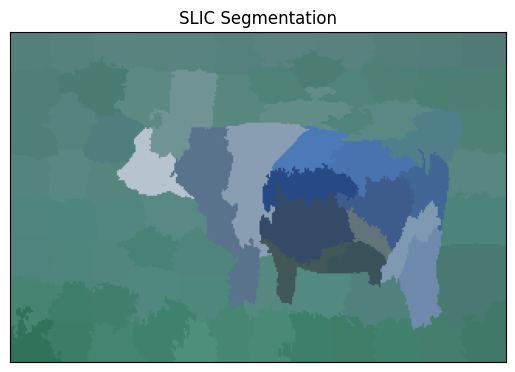

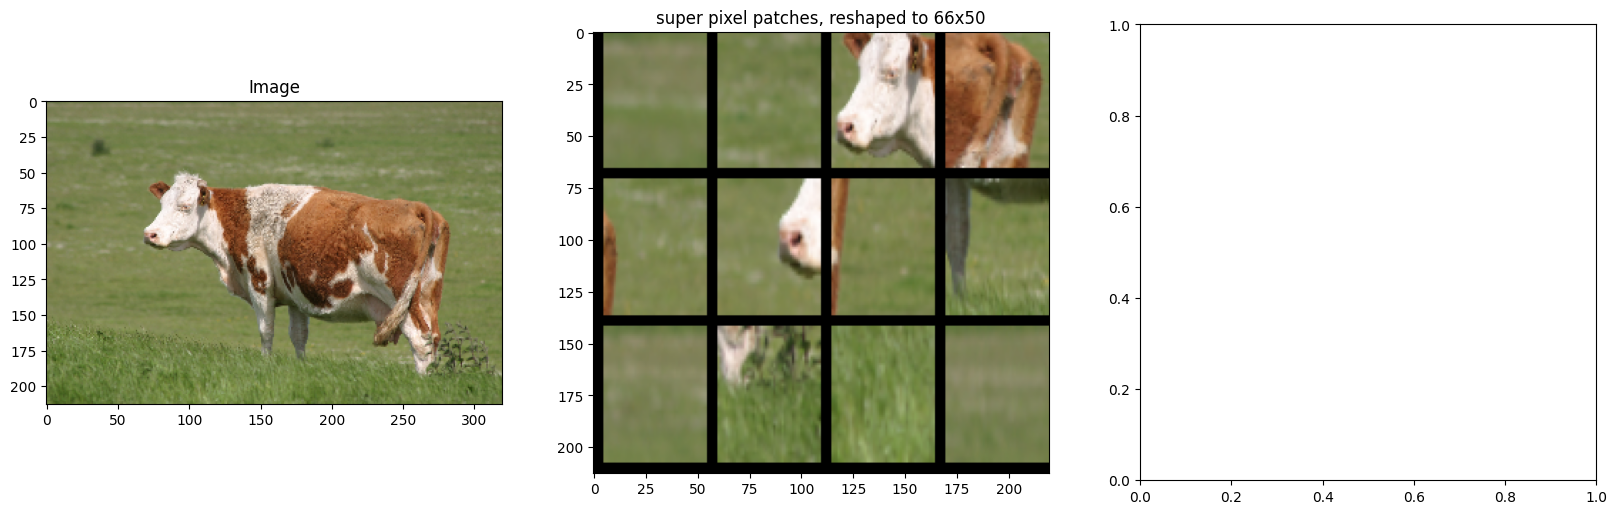

In [45]:
### YOUR CODE TO PLOT 12 images (original RGB + superpixel map + first 10 superpixels) ###

import random
import glob

def retrievePatches(imfilepath, folder):
    """
    Reads and returns all the patches corresponding to an image
    """
    _, prefix = os.path.split(imfilepath)
    patchname = folder+f'/{prefix[:-4]}'
    return glob.glob(patchname +'*.npy')


def patchGrid_vis(patches):
    """
    returns a grid of randomly sampled 12 patches corresponding to an image
    """
    patch_samples = sorted(random.sample(patches, 12))

    patchlist = []
    hbar = np.zeros((66, 5, 3), dtype=np.uint8); wbar = np.zeros((5, 220, 3), dtype=np.uint8)
    for i in range(0, len(patch_samples), 4):
        patch1 =  cv2.resize(np.load(patch_samples[i]), (50,66)) #np.load(patch_samples[i])
        patch2 = cv2.resize(np.load(patch_samples[i+1]), (50,66)) #np.load(patch_samples[i+1])
        patch3 = cv2.resize(np.load(patch_samples[i+2]), (50,66)) #np.load(patch_samples[i+1])
        patch4 = cv2.resize(np.load(patch_samples[i+3]), (50,66)) #np.load(patch_samples[i+1])
        assert patch1.shape ==  patch2.shape == patch3.shape == patch4.shape

        patch = np.hstack((hbar, patch1, hbar, patch2, hbar, patch3, hbar,patch4 ))
        patchlist.append(patch)
    allpatches = np.vstack( (patchlist[0], wbar, patchlist[1], wbar, patchlist[2], wbar))
    return allpatches


##############################################################################################################################
#################################################  Function call #############################################################
##############################################################################################################################
# ci = 0
trainfolder = msrc_directory + f'/train'
testfolder = msrc_directory + f'/test'

i=12
for i in range(12):
    file = train_imfiles[i]
    image = cv2.imread(file)[:,:,::-1]
    patches = retrievePatches( file, trainfolder) # read patches for a train image.
    patchgrid =  patchGrid_vis(patches)
    slicmap = slic(image, n_segments=100, compactness=10)
    slicmap = superpixel_plot(image, slicmap,title = f"SLIC Segmentation")
    f,plts = plt.subplots(1,3, figsize = (20,10))
    plts[0].imshow(image)
    plts[0].set_title('Image')
    plts[1].imshow(patchgrid)
    plts[1].set_title('super pixel patches, reshaped to 66x50')
    plts[2].imshow(slicmap)
    plts[2].set_title('Superpixel map')

### Question 6: Deep Network (10 points)

You could use a pre-trained network (like VGG) and replace the last few layers with a fully connected layer.

In [74]:
import torch
import torch.nn as nn
import torchvision.models as models

In [84]:
is_cuda_available = torch.cuda.is_available()
device = torch.device("cuda:0" if is_cuda_available else "cpu")
print(device)

def to_device(args):
    return [arg.to(device) for arg in args]

# Model definition
class SegmentationNN(nn.Module):
    def __init__(self, no_of_classes=10):
        super(SegmentationNN, self).__init__()

        # Load the pre-trained ResNet model
        resnet18 = self.resnet18_backbone()

        # Replace the final classification layer for segmentation
        in_channels = resnet18.fc.in_features
        resnet18.fc = nn.Sequential(
            nn.Linear(in_channels, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, no_of_classes)
        )
        self.model = resnet18

    def resnet18_backbone(self):
        # Load pre-trained ResNet-18 model
        resnet18 = models.resnet18(pretrained=True)

        # Freeze weights
        for param in resnet18.parameters():
            param.requires_grad = False

        return resnet18

    def forward(self, x):
        # Forward Pass
        x = self.model(x)
        return x



cuda:0


### Question 7: Optimizer (10 points)

Finally, we define the classification loss and optimizer such that we can learn a superpixel classifier from the backproporgation algorithm.

In [76]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
import torch.nn as nn


In [83]:

# Optimizer
class Solver(object):
    def __init__(self, model, num_epochs=5, learning_rate=5e-4):
        self.model = model
        self.num_epochs = num_epochs
        self.lossfn = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.scheduler = ReduceLROnPlateau(self.optimizer, factor=0.1, patience=5, verbose=True)
        self.iterations = 0

    def train(self, train_loader, val_loader=None):
        # Your code
        for epoch in range(self.num_epochs):
            self.model.train()
            starttime = time.time()
            losses = []
            accuracies = []

            for i, sample in tqdm(enumerate(train_loader)):
                image, label = to_device(sample)
                predvec = self.model(image)

                # Compute loss
                loss = self.lossfn(predvec, label)
                losses.append(loss.item())

                # Gradient descent
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                # Compute accuracy
                _, preds = torch.max(predvec, 1)
                acc = torch.sum(preds == label) / label.size(0)
                accuracies.append(acc.item())
                self.iterations += 1

            # Process end of epoch
            endtime = time.time() - starttime
            avg_loss = sum(losses) / len(losses)
            avg_acc = sum(accuracies) / len(accuracies)
            self.scheduler.step(avg_loss)
            print(f"Epoch: {epoch}/{self.num_epochs} ({self.iterations:.2f} iters) took {endtime/60:.2f} mins || Acc: {avg_acc:.2f} || Loss: {avg_loss:.2f}")

            if val_loader:
                test_loss, test_acc = self.evaluate(val_loader)

        print("Done training")
        # pass

    def evaluate(self, val_loader):
      # Set the model in evaluation mode
      self.model.eval()
      starttime = time.time()
      losses = []
      accuracies = []
      true = 0
      n_samples = 0

      # Disable gradient computation for evaluation
      with torch.no_grad(): #inference manager
          for i, sample in tqdm(enumerate(val_loader)):
              image, label = to_device(sample)
              predvec = self.model(image)

              # Compute loss
              loss = self.lossfn(predvec, label)
              losses.append(loss.item())

              # Compute accuracy
              _, preds = torch.max(predvec, 1)
              true += torch.sum(preds == label)
              n_samples += label.size(0)

              # Calculate accuracy for the current batch
              acc = true / n_samples
              accuracies.append(acc.item())

      # Calculate elapsed time for evaluation
      endtime = time.time() - starttime

      # Calculate the average accuracy and loss over all batches
      avg_acc = sum(accuracies) / len(accuracies)
      avg_loss = sum(losses) / len(losses)

      # Print the evaluation results
      print(f"Validation: took {endtime/60:.2f} mins || Acc: {avg_acc:.2f} || Loss: {avg_loss:.2f}")

      return avg_loss, avg_acc

### Question 8: Putting it together (50 points)

Train your network and observe the loss in time.
During the inference stage, combine the SLIC Superpixels' predicted labels to form the whole input image's superpixel segmentation results.
The following 4 items are the primary graded components:

1. You must randomly split the whole dataset into train and test subset (80:20 split is fine).
2. You must show the training loss of the classifier after every epoch
3. You must show the training accuracy and test accuracy of the classifier after training.
4. You must plot as least one visualization showing the test segmentation map vs. ground truth segmentation map.

In [85]:
from torch.utils.data import DataLoader, random_split

# load the data
# Define your custom SegmentationData dataset class (as defined in Question 6)

# Define the SegmentationNN model class (as defined in Question 6)

# Define the Solver class (as defined in Question 7)

# Using Mean and std values of Imagenet, Resnet (Default used in pytorch)link:- https://pytorch.org/hub/pytorch_vision_resnet/
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

custom_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),#As mentioned in the instructions to rescale the images
        transforms.RandomHorizontalFlip(),  # Randomly flip the images horizontally for data augmentation (optional)
        # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust color (optional)
        # transforms.RandomRotation(degrees=15),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
        ])
batch_size = 32
# load the data
trainset = SegmentationData(path =msrc_directory,  mode = 'train', transform=custom_transforms)
valset = SegmentationData(path =msrc_directory,  mode = 'test', transform=custom_transforms)

# data loader
train_loader = data.DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = data.DataLoader(dataset=valset, batch_size=batch_size, shuffle=True, num_workers=2)

# next_batch = next(iter(train_loader))
# image_shape = next_batch[0][0].shape
# print("Image shape:", image_shape)
# print("Image shape:", iter(train_loader).next()[0][0].shape)
print(f" Samples in train_loader: {len(train_loader)}")
print(f" Samples in val_loader: {len(val_loader)}")

# model
model = SegmentationNN().to(device)
solver = Solver(model, learning_rate=1e-4, num_epochs=10)


# train the model
solver.train(train_loader, val_loader)

trainloader length11434
testloader length3004
 Samples in train_loader: 358
 Samples in val_loader: 94


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
358it [00:42,  8.42it/s]

Epoch: 0/10 (358.00 iters) took 0.71 mins || Acc: 0.57 || Loss: 1.31



94it [00:12,  7.57it/s]

Validation: took 0.21 mins || Acc: 0.75 || Loss: 0.81



358it [00:42,  8.40it/s]

Epoch: 1/10 (716.00 iters) took 0.71 mins || Acc: 0.73 || Loss: 0.79



94it [00:11,  8.15it/s]

Validation: took 0.19 mins || Acc: 0.80 || Loss: 0.64



358it [00:42,  8.50it/s]

Epoch: 2/10 (1074.00 iters) took 0.70 mins || Acc: 0.76 || Loss: 0.69



94it [00:11,  8.31it/s]

Validation: took 0.19 mins || Acc: 0.81 || Loss: 0.57



358it [00:43,  8.16it/s]

Epoch: 3/10 (1432.00 iters) took 0.73 mins || Acc: 0.77 || Loss: 0.64



94it [00:09,  9.41it/s]

Validation: took 0.17 mins || Acc: 0.80 || Loss: 0.55



358it [00:41,  8.53it/s]

Epoch: 4/10 (1790.00 iters) took 0.70 mins || Acc: 0.78 || Loss: 0.60



94it [00:11,  8.37it/s]

Validation: took 0.19 mins || Acc: 0.81 || Loss: 0.53



358it [00:43,  8.24it/s]

Epoch: 5/10 (2148.00 iters) took 0.73 mins || Acc: 0.79 || Loss: 0.57



94it [00:11,  8.26it/s]

Validation: took 0.19 mins || Acc: 0.81 || Loss: 0.53



358it [00:42,  8.49it/s]

Epoch: 6/10 (2506.00 iters) took 0.70 mins || Acc: 0.79 || Loss: 0.57



94it [00:11,  8.23it/s]

Validation: took 0.19 mins || Acc: 0.82 || Loss: 0.50



358it [00:42,  8.37it/s]

Epoch: 7/10 (2864.00 iters) took 0.71 mins || Acc: 0.79 || Loss: 0.55



94it [00:12,  7.34it/s]

Validation: took 0.22 mins || Acc: 0.83 || Loss: 0.50



358it [00:42,  8.46it/s]

Epoch: 8/10 (3222.00 iters) took 0.71 mins || Acc: 0.80 || Loss: 0.54



94it [00:10,  9.14it/s]


Validation: took 0.17 mins || Acc: 0.83 || Loss: 0.51


358it [00:42,  8.51it/s]

Epoch: 9/10 (3580.00 iters) took 0.70 mins || Acc: 0.81 || Loss: 0.52



94it [00:11,  8.46it/s]

Validation: took 0.19 mins || Acc: 0.81 || Loss: 0.50
Done training


### Question 9: Bonus Question (20 points, OPTIONAL):

IMPORTANT: No matter which option you choose, you can earn a maximum of 20 points for this section.

We always want to increase the classifier accuracy and achieve a better performance by building a complicated deep learning model. There are a lot of tricks which are very popular and work in practice. Try to implement either of following two,

1. Could you effictively fuse different deep features from multiple layers in your network? You are welcome to use the pretrained network. Does your network achieve a better accuracy? There are a lot of exploration in the literature, including ION (Inside-Outside Net) [1], Hypercolumns [2], and PixelNet [3]. The following figure illustrates ION architecture combining features from different layers. Can you do similar thing for our Superpixel classifier?

2. Could you build a Multi-resolution network to explore the effectiveness of the multi-scale on the task of Superpixels segmentation? By multi-scale, we mean multiple resolutions of superpixels. See [4] for an example.

[1] Inside-Outside Net: Detecting Objects in Context with Skip Pooling and Recurrent Neural Networks

[2] Hypercolumns for Object Segmentation and Fine-grained Localization

[3] PixelNet: Representationofthe pixels, by the pixels, and for the pixels

[4] Feedforward semantic segmentation with zoom-out features

In [ ]:
# Bonus
